# Modules

In [4]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.interpolate import splev, splrep, interp1d
import scipy.optimize as opt
from scipy.signal import find_peaks

import glob

from pdastro import *

# Definitions

In [8]:
def diff(params, f_tmp, f_tmp_err, f_obs, f_obs_err):
    """calculate the difference between two light curves"""
    a, b = params
    f_obs_new = a * f_obs + b
    err = np.sqrt(f_tmp_err**2+f_obs_err**2)
    chi2 = (f_obs_new - f_tmp)**2 / err**2
    
    return np.sum(chi2)


def find_t_peak(t, f, t_range=None):
    if t_range is None:
        t_peak = t[np.argmax(f)]
    else:
        t_min = t_range[0]
        t_max = t_range[1]
        f = f[(t<t_max) & (t>t_min)]
        t = t[(t<t_max) & (t>t_min)]
        t_peak = t[np.argmax(f)]
    
    return t_peak


def find_t_shift(t1, f1, t2, f2, t_range=None):
    t_peak1 = find_t_peak(t1, f1, t_range=t_range)
    t_peak2 = find_t_peak(t2, f2, t_range=t_range)
    
    return t_peak2 - t_peak1


def get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err, t_range=None, t_peaks=None):
    """get optimized scale factor tshift, a, b
    t1, f1: template 
    t2, f2: f2_new = a * f2 + b
    """

    if t_peaks is None:
        if t_range is None:
            tshift = find_t_shift(t1, f1, t2, f2)
        elif t_range is not None:
            tshift = find_t_shift(t1, f1, t2, f2, t_range=t_range)
    elif t_peaks is not None:
        tshift = t_peaks[1] - t_peaks[0]
    
    t2_shifted = t2 - tshift

    tmin = max(t1.min(), t2_shifted.min())
    tmax = min(t1.max(), t2_shifted.max())
    
    t_range = t2_shifted[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    f1_new = splev(t_range, splrep(t1[::2], f1[::2], k=1))
    f1_new_err = splev(t_range, splrep(t1[::2], f1_err[::2], k=1))
    f2_new = f2[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    f2_new_err = f2_err[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    # get optimzied scale f2_new = a * f2 + b
    guess = (1, 0)
    res = opt.minimize(diff, guess, args=(f1_new, f1_new_err, f2_new, f2_new_err))
    a, b = res['x'][0], res['x'][1]
    
    return tshift, a, b

In [72]:
def lc_indices(df, n_sigma=3.0, nerr_sigma=3.0):
    "return the indices of the table of usable values"
    
    jyas2_med = np.nanmedian(df['Jyas2'])
    jyas2_std = np.nanstd(df['Jyas2'])
    jyas2err_med = np.nanmedian(df['Jyas2_err'])
    jyas2err_std = np.nanstd(df['Jyas2_err'])

    if nerr_sigma!=None:
        inds = np.where((df['Jyas2_err']< jyas2err_med + nerr_sigma*jyas2err_std) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]
    else:
        # inds = np.where((df['Jyas2_err']< jyas2err_med + 0.34e-6) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]   # this was for ec0814
        # inds = np.where((abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std) & (df['Jyas2_err']<1.0e-6))[0]
        inds = np.where((df['fluxADU']< 1000) & (df['Jyas2_err']<1.0e-6))[0]
        
    return(inds)



def get_bins(df, t):
    t_range = np.linspace(min(t),max(t),100)
    skip_inds = []
    bins_t = []
    t_bvals = [t_range[0]]
    for i in range(len(t_range)-1):
        # if i not in skip_inds:
            lo_i = i
            skip_inds.append(i)
            up_i = i+1
            # bin_i = np.where((df.t['mjd']>t_range[lo_i]) & (df.t['mjd']<t_range[up_i]))[0]
            bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
            while len(bin_i)<50 and up_i!=len(t_range)-1:
                skip_inds.append(up_i)
                up_i += 1
                bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
                
            bins_t.append(bin_i)
            t_bvals.append(t_range[up_i])
    return(bins_t, t_bvals)


def get_LCbins(df, bin_sz):

    sort_inds = df.ix_sort_by_cols('mjd')

    bins_inds = []
    
    for i in range(0, len(sort_inds), bin_sz):
        if len(sort_inds) - (i+bin_sz) < bin_sz or len(sort_inds) - i < bin_sz:
            bins_inds.append(sort_inds[i:])
            break
        else:
            bins_inds.append(sort_inds[i:i + bin_sz])

    return(bins_inds)

In [12]:
def convert_Jy2mag(x_jy):
    # x_jy in micro-janskys
    mag = 23.9 - 2.5*np.log10(x_jy*1e6)
    return('{:.2f}'.format(round(mag, 2)))



def get_mean_pix(img, x, y):
    """ get mean pixel values over 9 nearby pixels centered at (x, y)
        img: array
        x, y center"""
    mean = (img[y, x] + img[y, x-1] + img[y, x+1]
          + img[y-1,x]+ img[y-1,x-1]+ img[y-1,x+1]
          + img[y+1,x]+ img[y+1,x-1]+ img[y+1,x+1]).astype(np.float32)/9
    return mean

# The Model

In [15]:
### Read in model
LCm1_g = pd.read_csv('ecLCg_m1.csv')

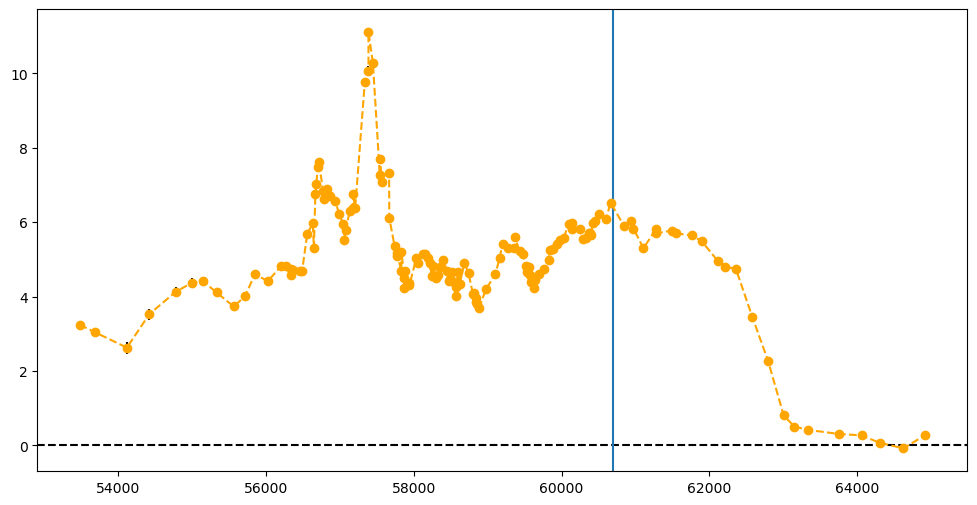

In [190]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(LCm1_g['mjd'], LCm1_g['mJyas2'], fmt='--o', ecolor='black', color='orange', yerr=LCm1_g['mJyas2_err'])
plt.axhline(y=0, linestyle='--', color='black')
plt.axvline(60700)

# 2nd Iteration -- Fit Model to LCs

### Segment 1

In [67]:
### Read in light curves -- ec0915 ccd 54, focused on big peak

url1 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730.html'
html1 = requests.get(url1).content
df_table1 = pd.read_html(html1)[-1]


IDs_good_fits_poly1 = [12, 13, 17, 18, 19, 25, 26, 27, 31, 35, 36, 37, 38, 
                       59, 61, 62, 63, 64, 72, 73, 74, 75, 77, 88, 90, 
                       105, 106, 137, 190, 191, 950, 952, 999, 998, 996]

df_list1 = []
for i in IDs_good_fits_poly1:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list1.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list1:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

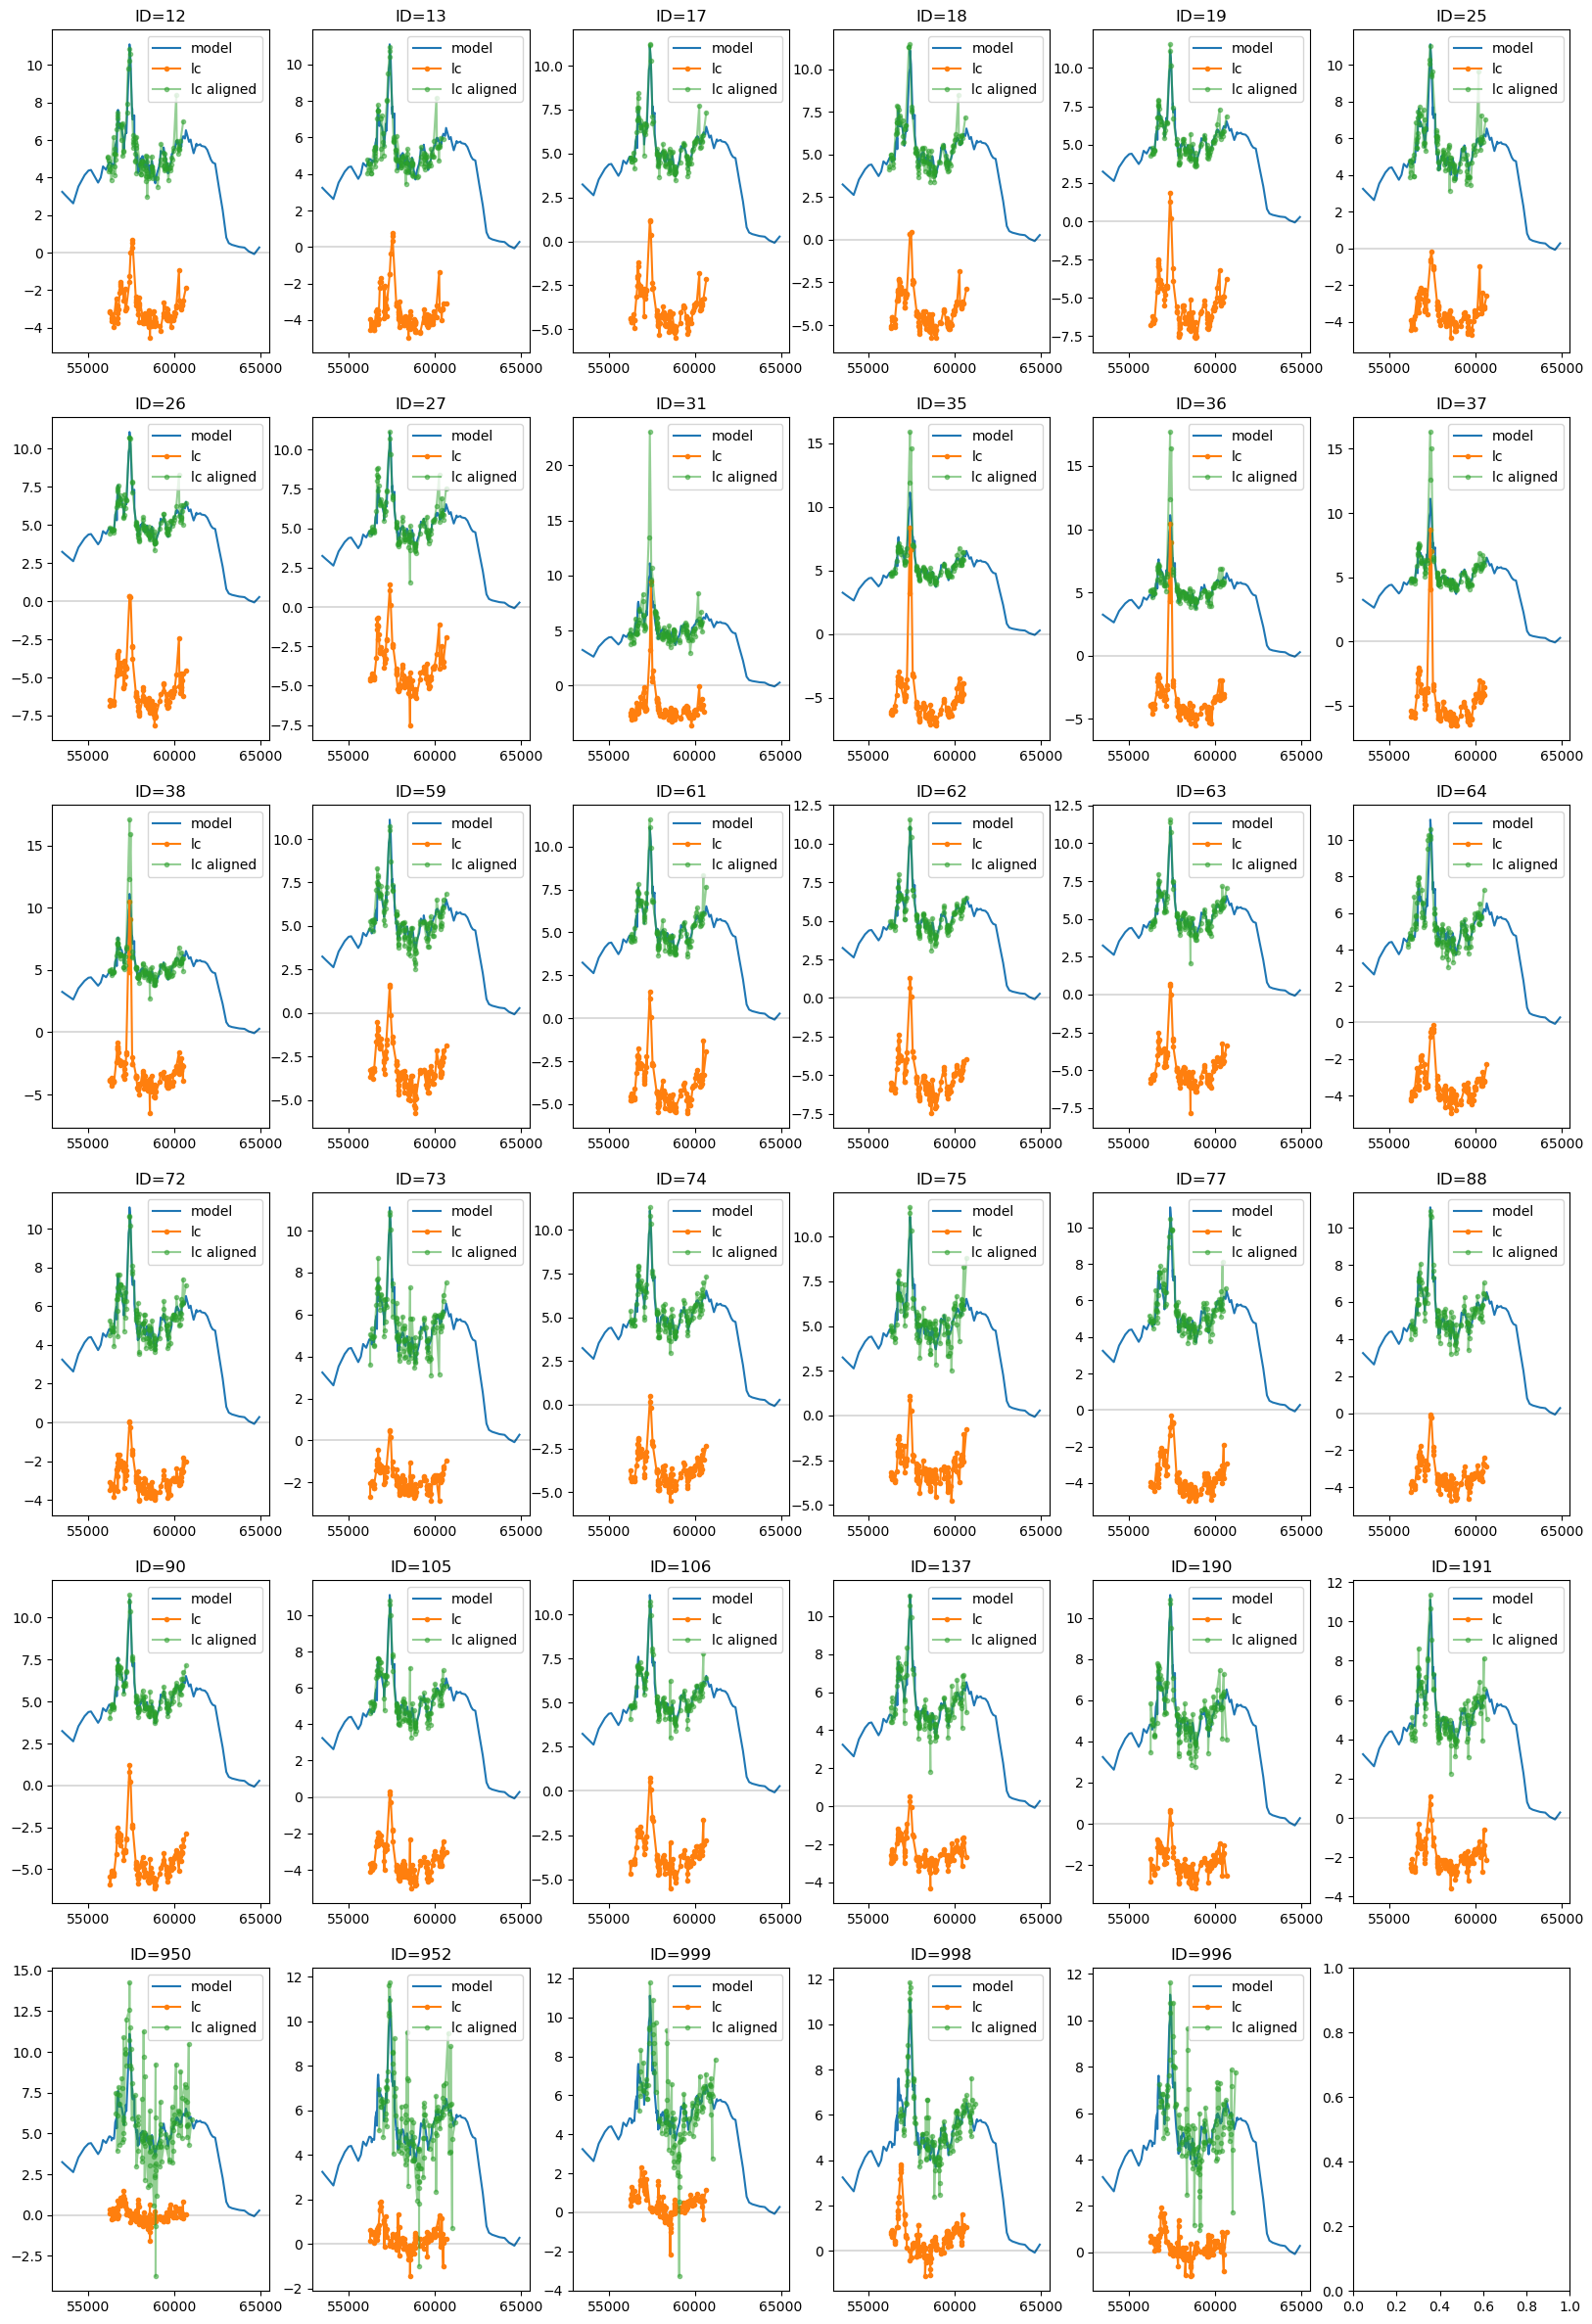

In [76]:
n_sigma1 = None
nerr_sigma1 = None

# Find the shift and fitting parameters for the model fitting to each light curve
t1 = LCm1_g['mjd'].values
f1 = LCm1_g['mJyas2'].values
f1_err = LCm1_g['mJyas2_err'].values

fig, axs = plt.subplots(6, 6, figsize=(20, 30))
axs = axs.flatten() 

tshifts_54 = []
a_norms_54 = []
b_offsets_54 = []

for i, df in enumerate(df_list1):
    g_inds = lc_indices(df, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t2, f2, f2_err, t1, f1, f1_err)

    tshifts_54.append(tshift)
    a_norms_54.append(a)
    b_offsets_54.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='model')
    ax.errorbar(t2, f2, label='lc', fmt='.-')
    ax.errorbar(t2+tshift, (f2 - b)/a, alpha=.5, label='lc aligned', fmt='.-')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

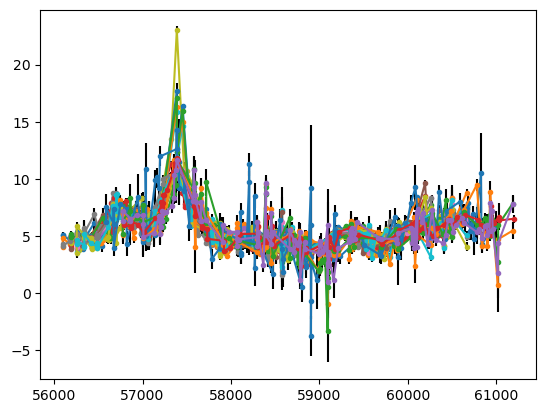

In [79]:
for i in range(len(tshifts_54)):
    df = df_list1[i]
    i_inds = lc_indices(df, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
    
    tshift_i = tshifts_54[i]
    a_i = a_norms_54[i]
    b_i = b_offsets_54[i]
    t_new = df['mjd'][i_inds] + tshift_i
    f_new = (df['mJyas2'][i_inds]-b_i)/a_i
    ferr_new = df['mJyas2_err'][i_inds]/a_i
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [84]:
### Put combined data into a data frame

tls1 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])
fls1 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])
ferrls1 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])

ord_inds1 = tls1.argsort()
tls1 = tls1[ord_inds1]
fls1 = fls1[ord_inds1]
ferrls1 = ferrls1[ord_inds1]

comb1_data = {'mjd': tls1, 'mJyas2': fls1, 'mJyas2_err': ferrls1}
comb1 = pdastrostatsclass()
comb1.t = comb1.t.assign(**comb1_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve

# bins1, t_bvals1 = get_bins(comb1, tls1)
bins1 = get_LCbins(comb1,45)
tmed1 = []
fmed1 = []
fmed_err1 = []
workinds1 = []
badinds1 = []

for i in range(len(bins1)):
    bin_i = bins1[i]
    comb1.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed1.append(np.average(comb1.t.loc[bin_i,'mjd'], weights=1-comb1.t.loc[bin_i,'mJyas2_err']/max(comb1.t.loc[bin_i,'mJyas2_err'])))
    fmed1.append(comb1.statparams['mean'])
    fmed_err1.append(comb1.statparams['mean_err'])
    workinds1.append(comb1.statparams['ix_good'])
    badinds1.append(comb1.statparams['ix_clip'])


tmed1 = np.array(tmed1)
fmed1 = np.array(fmed1)
fmed_err1 = np.array(fmed_err1)


### Find the peaks in combined light curve

tpeak1 = find_t_peak(tmed1, fmed1)

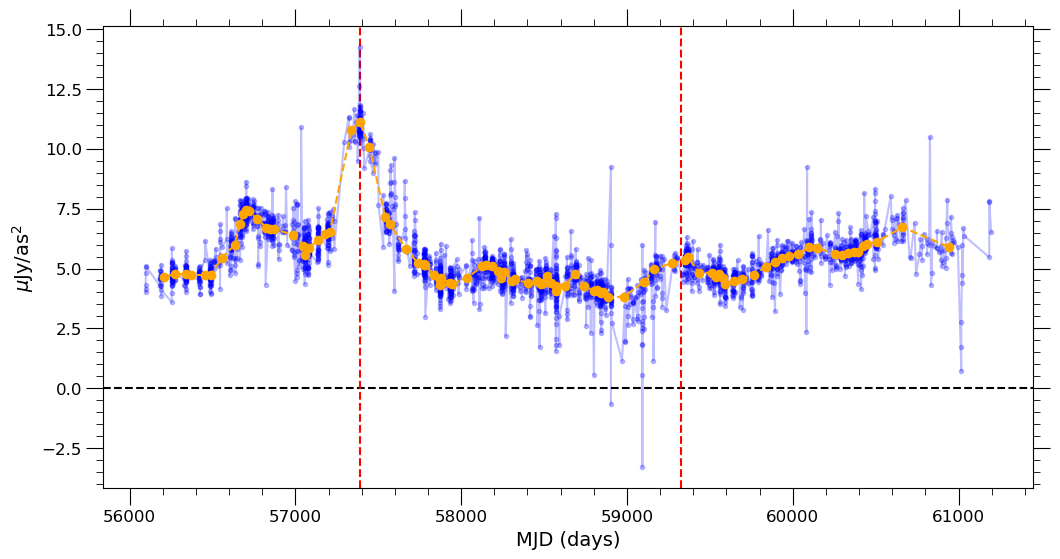

In [86]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter g', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds1 = [i for bn in workinds1 for i in bn]

pl_ax.errorbar(comb1.t.loc[winds1,'mjd'], comb1.t.loc[winds1,'mJyas2'], fmt='.-', color='blue', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed1, fmed1, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err1
pl_ax.axvline(x=tpeak1, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC.png', bbox_inches = 'tight', dpi=100)

pl_ax.axvline(x=59325, color='red', linestyle='--')

### Segment 2

In [93]:
### Read in light curves -- ec0915 ccd 57, focused on before big peak

url2 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/57/ec0915a57_poly1pos_g_tmpl523730.html'
html2 = requests.get(url2).content
df_table2 = pd.read_html(html2)[-1]

# IDs_good_fits_57 = [117, 119, 120, 135, 137, 152, 155]
IDs_good_fits_57 = [120, 135, 137, 155]

df_list2 = []
for i in IDs_good_fits_57:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/57/ec0915a57_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list2.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list2:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

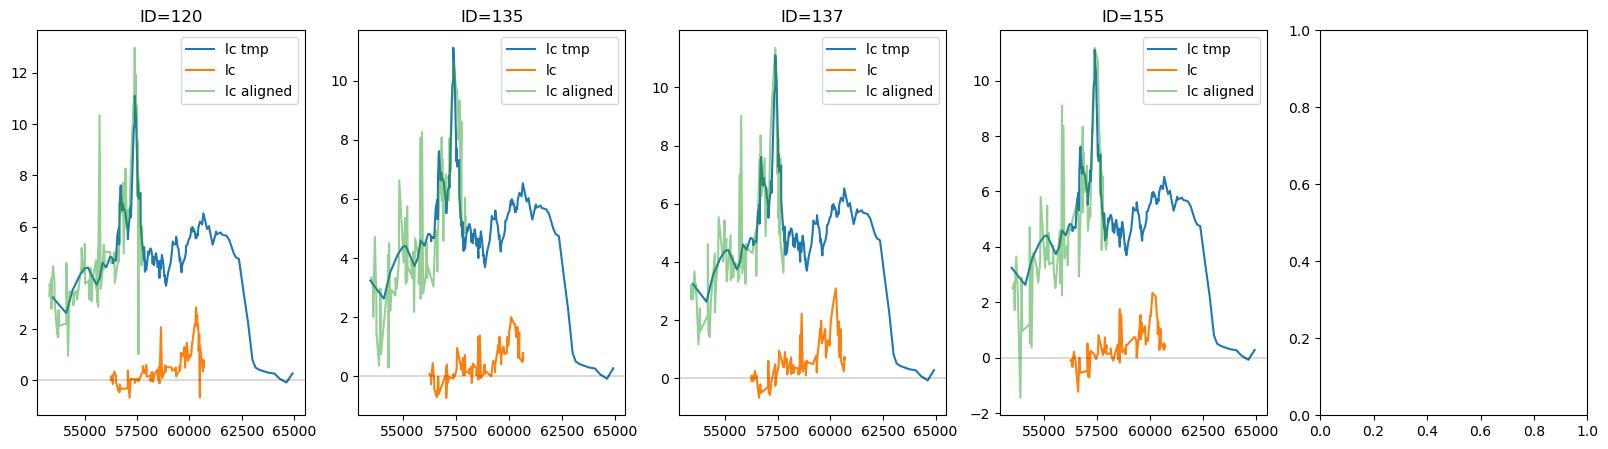

In [105]:
n_sigma2 = None
nerr_sigma2 = None

# Find the shift and fitting parameters for the model fitting to each light curve
t1 = LCm1_g['mjd'].values
f1 = LCm1_g['mJyas2'].values
f1_err = LCm1_g['mJyas2_err'].values

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs = axs.flatten() 

tshifts_57 = []
a_norms_57 = []
b_offsets_57 = []

for i, df in enumerate(df_list2):
    g_inds = lc_indices(df, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t2, f2, f2_err, t1, f1, f1_err)

    tshifts_57.append(tshift)
    a_norms_57.append(a)
    b_offsets_57.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.plot(t2, f2, label='lc')
    ax.plot(t2+tshift, (f2-b)/a, alpha=.5, label='lc aligned')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

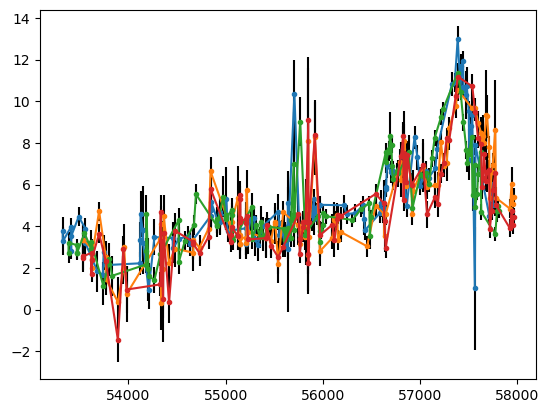

In [107]:
for i in range(len(tshifts_57)):
    df = df_list2[i]
    i_inds = lc_indices(df, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
    
    tshift_i = tshifts_57[i]
    a_i = a_norms_57[i]
    b_i = b_offsets_57[i]
    t_new = df['mjd'][i_inds] + tshift_i
    f_new = (df['mJyas2'][i_inds]-b_i)/a_i
    ferr_new = df['mJyas2_err'][i_inds]/a_i
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [119]:
### Put combined data into a data frame
tls2 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])
fls2 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])
ferrls2 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])

ord_inds2 = tls2.argsort()
tls2 = tls2[ord_inds2]
fls2 = fls2[ord_inds2]
ferrls2 = ferrls2[ord_inds2]


comb2_data = {'mjd': tls2, 'mJyas2': fls2, 'mJyas2_err': ferrls2}
comb2 = pdastrostatsclass()
comb2.t = comb2.t.assign(**comb2_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins2, t_bvals2 = get_bins(comb2, tls2)
bins2 = get_LCbins(comb2,20)
tmed2 = []
fmed2 = []
fmed_err2 = []
workinds2 = []
badinds2 = []

for i in range(len(bins2)):
    bin_i = bins2[i]
    comb2.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed2.append(np.average(comb2.t.loc[bin_i,'mjd'], weights=1-comb2.t.loc[bin_i,'mJyas2_err']/max(comb2.t.loc[bin_i,'mJyas2_err'])))
    fmed2.append(comb2.statparams['mean'])
    fmed_err2.append(comb2.statparams['mean_err'])
    workinds2.append(comb2.statparams['ix_good'])
    badinds2.append(comb2.statparams['ix_clip'])


tmed2 = np.array(tmed2)
fmed2 = np.array(fmed2)
fmed_err2 = np.array(fmed_err2)


### Find the peaks in combined light curve
tpeak2 = find_t_peak(tmed2, fmed2)

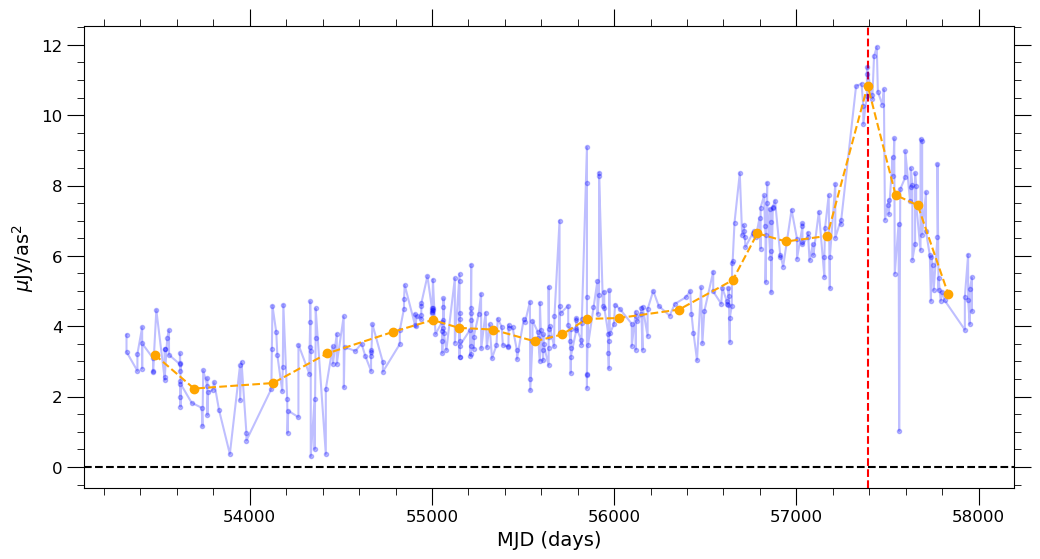

In [121]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds2 = [i for bn in workinds2 for i in bn]

pl_ax.errorbar(comb2.t.loc[winds2,'mjd'], comb2.t.loc[winds2,'mJyas2'], color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed2,fmed2, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err2
pl_ax.axvline(x=tpeak2, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)
# pl_fig.savefig('ec0915_LC2.png', bbox_inches = 'tight', dpi=100)

### Segment 3

In [125]:
### Read in light curves -- ec0915 ccd 54 (comet), focused on tail end

url3 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/goodpos_g/ec0915/54/ec0915a54_goodpos_g_tmpl523730.html'
html3 = requests.get(url3).content
df_table3 = pd.read_html(html3)[-1]

IDs_comet = [1321, 1322, 1371, 1372, 1421, 1422]

# df_list3 = []
# for i in range(len(df_table3)):
#     group_i = df_table3['group'][i]
#     ID_i = df_table3['ID'][i]

#     if group_i == 0:
#         url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/goodpos_g/ec0915/54/ec0915a54_goodpos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
#         temp_tab = pd.read_csv(url, sep='\s+')
#         df_list3.append(temp_tab)

df_list3 = []
for i in IDs_comet:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list3.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list3:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

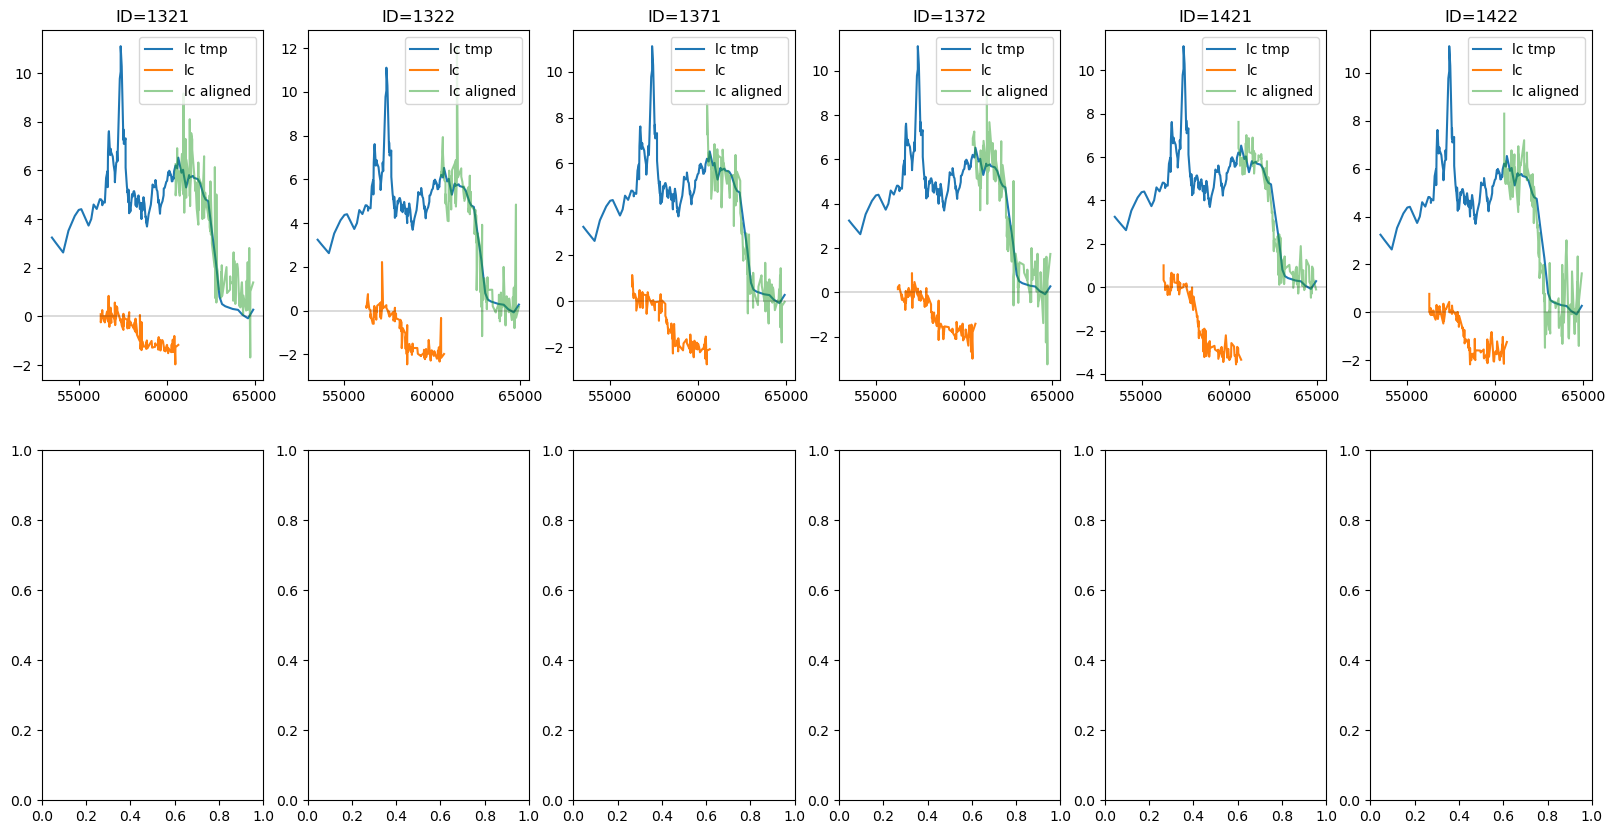

In [131]:
n_sigma3 = None
nerr_sigma3 = None


# Find the shift and fitting parameters for the model fitting to each light curve
t1 = LCm1_g['mjd'].values
f1 = LCm1_g['mJyas2'].values
f1_err = LCm1_g['mJyas2_err'].values

fig, axs = plt.subplots(2, 6, figsize=(20, 10))
axs = axs.flatten() 

tshifts_c = []
a_norms_c = []
b_offsets_c = []

for i, df in enumerate(df_list3):
    g_inds = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t2, f2, f2_err, t1, f1, f1_err, t_peaks=[t2[-1], t1[-1]])

    tshifts_c.append(tshift)
    a_norms_c.append(a)
    b_offsets_c.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.plot(t2, f2, label='lc')
    ax.plot(t2+tshift, (f2-b)/a, alpha=.5, label='lc aligned')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

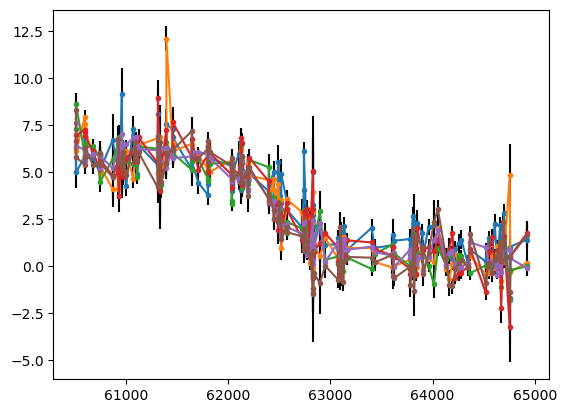

In [133]:
for i in range(len(tshifts_c)):
    df = df_list3[i]
    i_inds = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
    
    tshift_i = tshifts_c[i]
    a_i = a_norms_c[i]
    b_i = b_offsets_c[i]
    t_new = df['mjd'][i_inds] + tshift_i
    f_new = (df['mJyas2'][i_inds]-b_i)/a_i
    ferr_new = df['mJyas2_err'][i_inds]/a_i
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [135]:
### Put combined data into a data frame
tls3 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])
fls3 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])
ferrls3 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])

ord_inds3 = tls3.argsort()
tls3 = tls3[ord_inds3]
fls3 = fls3[ord_inds3]
ferrls3 = ferrls3[ord_inds3]


comb3_data = {'mjd': tls3, 'mJyas2': fls3, 'mJyas2_err': ferrls3}
comb3 = pdastrostatsclass()
comb3.t = comb3.t.assign(**comb3_data)


### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins3, t_bvals3 = get_bins(comb3, tls3)
bins3 = get_LCbins(comb3,45)
tmed3 = []
fmed3 = []
fmed_err3 = []
workinds3 = []
badinds3 = []

for i in range(len(bins3)):
    bin_i = bins3[i]
    comb3.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed3.append(np.average(comb3.t.loc[bin_i,'mjd'], weights=1-comb3.t.loc[bin_i,'mJyas2_err']/max(comb3.t.loc[bin_i,'mJyas2_err'])))
    fmed3.append(comb3.statparams['mean'])
    fmed_err3.append(comb3.statparams['mean_err'])
    workinds3.append(comb3.statparams['ix_good'])
    badinds3.append(comb3.statparams['ix_clip'])


tmed3 = np.array(tmed3)
fmed3 = np.array(fmed3)
fmed_err3 = np.array(fmed_err3)

<ErrorbarContainer object of 3 artists>

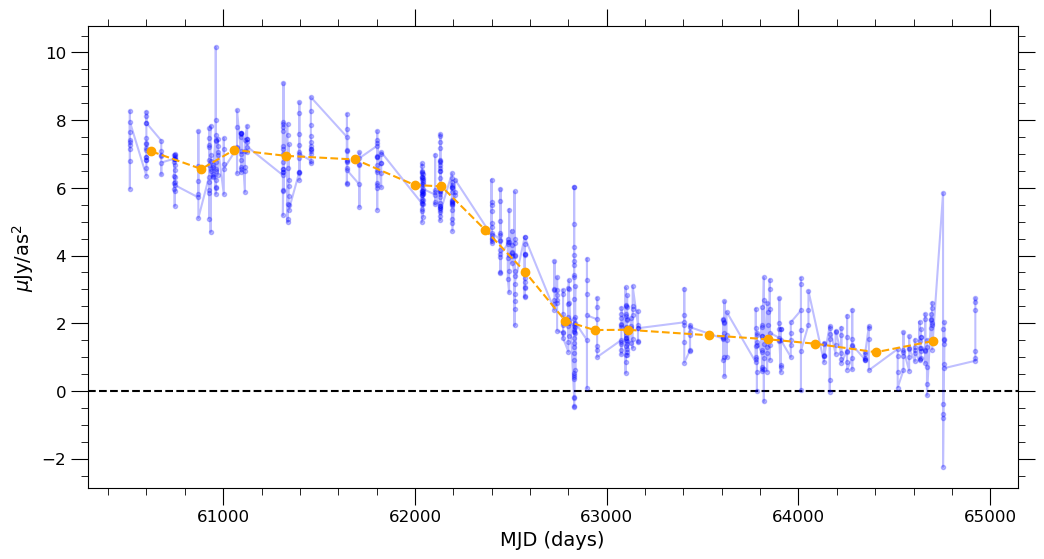

In [137]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds3 = [i for bn in workinds3 for i in bn]
f_offset = 1.0

pl_ax.errorbar(comb3.t.loc[winds3,'mjd'], comb3.t.loc[winds3,'mJyas2']+f_offset, color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed3,fmed3+f_offset, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err3
# pl_ax.axvline(x=tpeak3, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC3.png', bbox_inches = 'tight', dpi=100)

### Segment 4

In [144]:
### Read in light curves -- Armin positions, focused on plateau

url4 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/Armins_g/ec0915/54/ec0915a54_Arminspos_g_tmpl523730.html'
html4 = requests.get(url4).content
df_table4 = pd.read_html(html4)[-1]

df_list4 = []
for i in range(len(df_table4)):
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/Armins_g/ec0915/54/ec0915a54_Arminspos_g_tmpl523730_ID'+str(i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list4.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list4:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

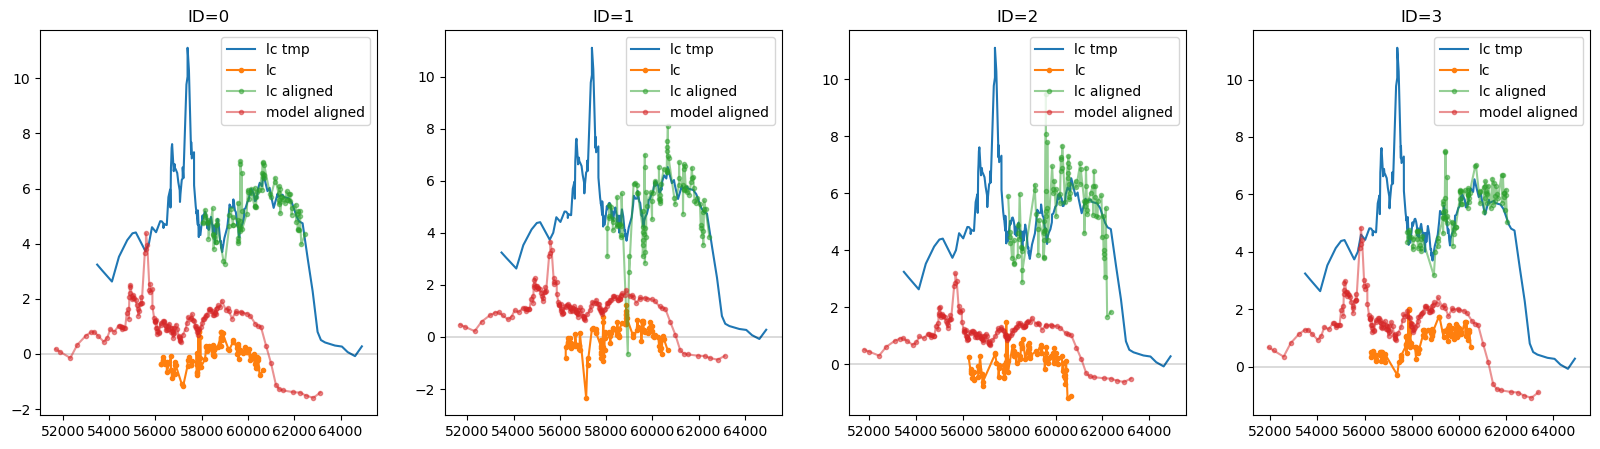

In [192]:
n_sigma4 = 10.0
nerr_sigma4 = 0.5


# Find the shift and fitting parameters for the model fitting to each light curve
t1 = LCm1_g['mjd'].values
f1 = LCm1_g['mJyas2'].values
f1_err = LCm1_g['mJyas2_err'].values
tp_loc1 = 60700

t_peaks_locs = [58900, 58900, 59000, 59150]


fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten() 

tshifts_A = []
a_norms_A = []
b_offsets_A = []

for i, df in enumerate(df_list4):
    g_inds = lc_indices(df, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values
    tp_loc2 = t_peaks_locs[i]

    tshift, a, b = get_tshift_scale_offset(t2, f2, f2_err, t1, f1, f1_err, t_peaks=[tp_loc2, tp_loc1])
    
    tshifts_A.append(tshift)
    a_norms_A.append(a)
    b_offsets_A.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.errorbar(t2, f2, label='lc', fmt='.-')
    ax.errorbar(t2+tshift, (f2-b)/a, alpha=.5, label='lc aligned', fmt='.-')
    ax.errorbar(t1-tshift, (f1+b)*a, alpha=.5, label='model aligned', fmt='.-')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

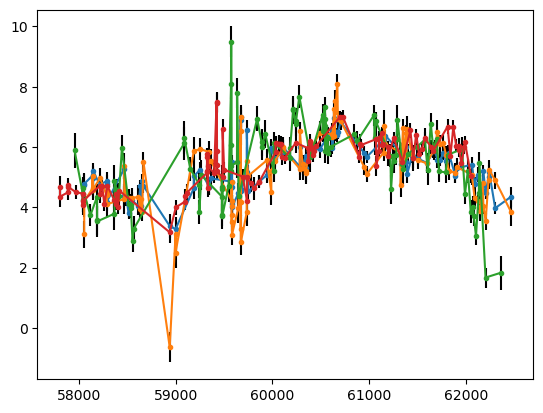

In [194]:
for i in range(len(tshifts_A)):
    df = df_list4[i]
    i_inds = lc_indices(df, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
    
    tshift_i = tshifts_A[i]
    a_i = a_norms_A[i]
    b_i = b_offsets_A[i]
    t_new = df['mjd'][i_inds] + tshift_i
    f_new = (df['mJyas2'][i_inds]-b_i)/a_i
    ferr_new = df['mJyas2_err'][i_inds]/a_i
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [207]:
tls4 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])
fls4 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])
ferrls4 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])

ord_inds4 = tls4.argsort()
tls4 = tls4[ord_inds4]
fls4 = fls4[ord_inds4]
ferrls4 = ferrls4[ord_inds4]


comb4_data = {'mjd': tls4, 'mJyas2': fls4, 'mJyas2_err': ferrls4}
comb4 = pdastrostatsclass()
comb4.t = comb4.t.assign(**comb4_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins4, t_bvals4 = get_bins(comb4, tls4)
bins4 = get_LCbins(comb4, 25)
tmed4 = []
fmed4 = []
fmed_err4 = []
workinds4 = []
badinds4 = []

for i in range(len(bins4)):
    bin_i = bins4[i]
    comb4.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed4.append(np.average(comb4.t.loc[bin_i,'mjd'], weights=1-comb4.t.loc[bin_i,'mJyas2_err']/max(comb4.t.loc[bin_i,'mJyas2_err'])))
    fmed4.append(comb4.statparams['mean'])
    fmed_err4.append(comb4.statparams['mean_err'])
    workinds4.append(comb4.statparams['ix_good'])
    badinds4.append(comb4.statparams['ix_clip'])


tmed4 = np.array(tmed4)
fmed4 = np.array(fmed4)
fmed_err4 = np.array(fmed_err4)

<ErrorbarContainer object of 3 artists>

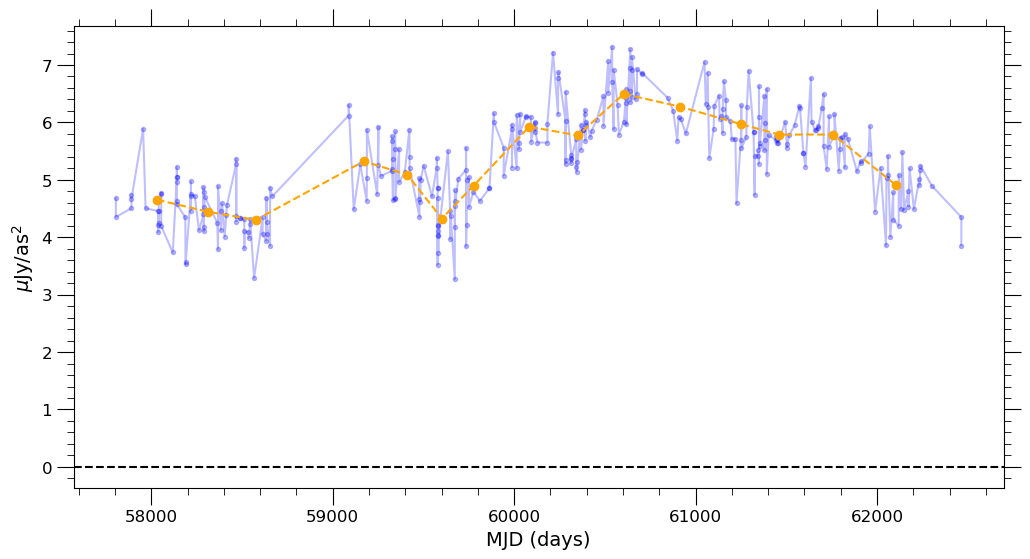

In [209]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds4 = [i for bn in workinds4 for i in bn]

pl_ax.errorbar(comb4.t.loc[winds4,'mjd'], comb4.t.loc[winds4,'mJyas2'], color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed4,fmed4, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err4
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC4.png', bbox_inches = 'tight', dpi=100)

### Combine Segments -- Model Iteration 2

In [217]:
tlsm = np.concatenate([comb1.t.loc[:,'mjd'], comb2.t.loc[:,'mjd'], comb3.t.loc[:,'mjd'], comb4.t.loc[:,'mjd']])
flsm = np.concatenate([comb1.t.loc[:,'mJyas2'], comb2.t.loc[:,'mJyas2'], comb3.t.loc[:,'mJyas2'], comb4.t.loc[:,'mJyas2']])
ferrlsm = np.concatenate([comb1.t.loc[:,'mJyas2_err'], comb2.t.loc[:,'mJyas2_err'], comb3.t.loc[:,'mJyas2_err'], comb4.t.loc[:,'mJyas2_err']])


ord_indsm = tlsm.argsort()
tlsm = tlsm[ord_indsm]
flsm = flsm[ord_indsm]
ferrlsm = ferrlsm[ord_indsm]


combm_data = {'mjd': tlsm, 'mJyas2': flsm, 'mJyas2_err': ferrlsm}
combm = pdastrostatsclass()
combm.t = combm.t.assign(**combm_data)

In [260]:
binsm = get_LCbins(combm,100)
tmedm = []
fmedm = []
fmed_errm = []
workindsm = []
badindsm = []

for i in range(len(binsm)):
    bin_i = binsm[i]
    combm.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmedm.append(np.average(combm.t.loc[bin_i,'mjd'], weights=1-combm.t.loc[bin_i,'mJyas2_err']/max(combm.t.loc[bin_i,'mJyas2_err'])))
    fmedm.append(combm.statparams['mean'])
    fmed_errm.append(combm.statparams['mean_err'])
    workindsm.append(combm.statparams['ix_good'])
    badindsm.append(combm.statparams['ix_clip'])
    

tmedm = np.array(tmedm)
fmedm = np.array(fmedm)
fmed_errm = np.array(fmed_errm)

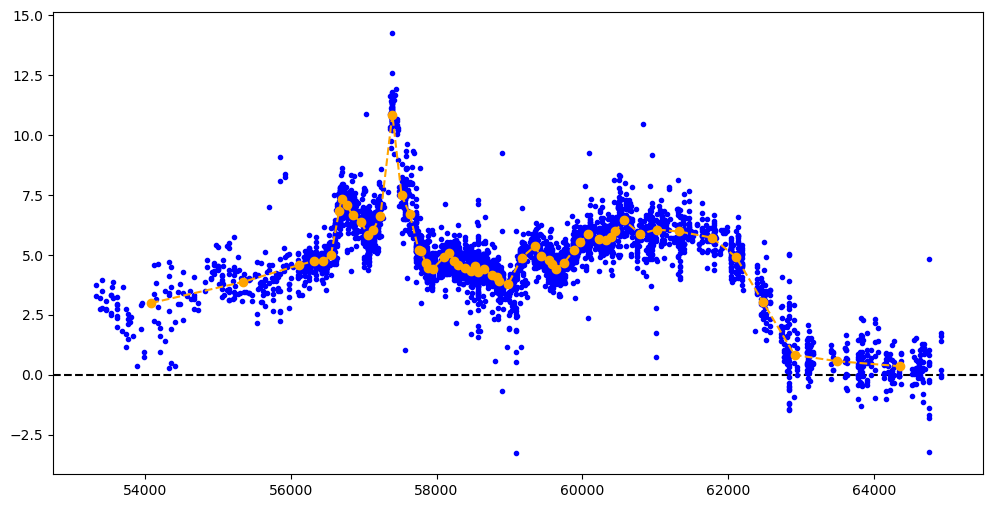

In [261]:
plt.subplots(dpi = 100, figsize = [12,6])
windsm = [i for bn in workindsm for i in bn]
plt.errorbar(combm.t.loc[windsm,'mjd'], combm.t.loc[windsm,'mJyas2'], fmt='.', ecolor='black', color='blue')
plt.errorbar(tmedm, fmedm, fmt='--o', ecolor='black', color='orange')
plt.axhline(y=0, linestyle='--', color='black')

In [264]:
gmodel = {'mjd':tmedm, 'mJyas2':fmedm, 'mJyas2_err':fmed_errm}
gmodel_d = pd.DataFrame(gmodel)

In [266]:
gmodel_d.to_csv('ecLCg_m2.csv', index=False)